# 1.Data & Sentiment Analysis Overview

We analysis on data to find out the relations with our reviews sentiment analysis research.
And then We apply sentiment analysis and find out the difference between them.

### Step 1. Analysis text relation with time
1. Time period
2. Reviwes Number by Month.
### Step 2. Sentiment Analysis - VADER

VADER is sensitive to both case and punctuation, including emojis, which can convey meaningful sentiment information.
Text Processing: We do nothing to text, as VADER is sensitive to both case and punctuation, including emojis. Expect translation to English that We already did in previous Cleaning steps.

### Step 3. Impute NaN of sentiment score with mean, by grouping month. 
Not-commented reviews is not analysized with sentiment score, we impute then.


In [19]:
#!pip install vaderSentiment
#!pip install dtaidistance

In [20]:
import os

import pandas as pd
import numpy as np
from dtaidistance import dtw

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tqdm

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# 2. Data Analysis

### Analysis text relation with time
### Step 1. Review number Distribution
Accoding to the number, Barcelona and Paris is popular city. Florence and Vience is un-popular city

### Step 2. Review number Distribution along with Time
After Jan 2023, number of reviews dramatically increased and 

In [21]:
save_imputed_year_month_remove_youngest_date_of_first_day_byCities_and_imputed_IsCommented_file_path = 'C:/Users/surface/DSDM/Semesters/semester2/text mining/Final Project/cleaned_data/Step_2nd_cleaning_imputed_year_month_remove_youngest_date_of_first_day_byCities_and_imputed_IsCommented.csv'

df = pd.read_csv(save_imputed_year_month_remove_youngest_date_of_first_day_byCities_and_imputed_IsCommented_file_path)
df['Review_Date'] = pd.to_datetime(df['Review_Date'])# set up to DateTime mode
df.tail()

,Reviewer_Name,Review_Body,Review_Date,Rating,Country,Helpful_Tag,Travel Category,Require_Translate,City,Attraction_Rank,Year,Month,Is_Commented
13730,Anonymous,There are no comments available for this review,2024-03-15,4,NaN,NaN,NaN,False,Venice,top1,2024,March,False
13731,claude,Take a citizen pass and a vaporetto subscripti...,2024-03-15,5,France,Helpful,solo,True,Venice,top2,2024,March,True
13732,Birgit,A highlight of our holiday week in Venice. Gre...,2024-03-15,5,Germany,Helpful,a partner or spouse,True,Venice,top2,2024,March,True
13733,Sharon,There are no comments available for this review,2024-03-15,4,Ireland,NaN,friends,False,Venice,top2,2024,March,False
13734,Anonymous,There are no comments available for this review,2024-03-16,1,NaN,NaN,NaN,False,Venice,top2,2024,March,False


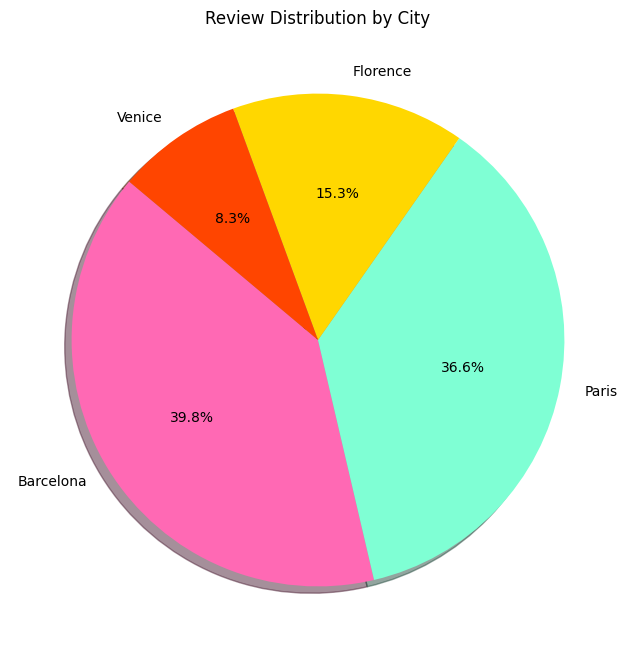

City
Barcelona    5417
Paris        4990
Florence     2086
Venice       1130
Name: count, dtype: int64


In [22]:
df = df[df['City'] != 'Ljubljana']
city_counts = df['City'].value_counts()
fancy_colors = ['#FF69B4', '#7FFFD4', '#FFD700', '#FF4500']

# Define a set of fancy colors for the pie chart
fancy_colors = ['#FF69B4', '#7FFFD4', '#FFD700', '#FF4500']

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(city_counts, labels=city_counts.index, colors=fancy_colors, autopct='%1.1f%%', startangle=140, shadow=True)
plt.title('Review Distribution by City')
plt.show()

print(city_counts)

### Step 1. Analysis text relation with time

In [23]:
# Group by 'City' and sort each group by 'Review_Date'
sorted_groups = df.groupby('City').apply(lambda x: x.sort_values('Review_Date')).reset_index(drop=True)

# Now, since 'City' is only a column, this should work without causing an error
time_periods = sorted_groups.groupby('City')['Review_Date'].agg([min, max])

# Reset index to make 'City' a column again (optional, in this case, 'City' is already a column)
time_periods.reset_index(inplace=True)

# Display the time periods for each city
print(time_periods)


        City        min        max
0  Barcelona 2021-08-01 2024-03-17
1   Florence 2021-07-31 2024-03-15
2      Paris 2021-07-28 2024-03-17
3     Venice 2021-08-10 2024-03-16


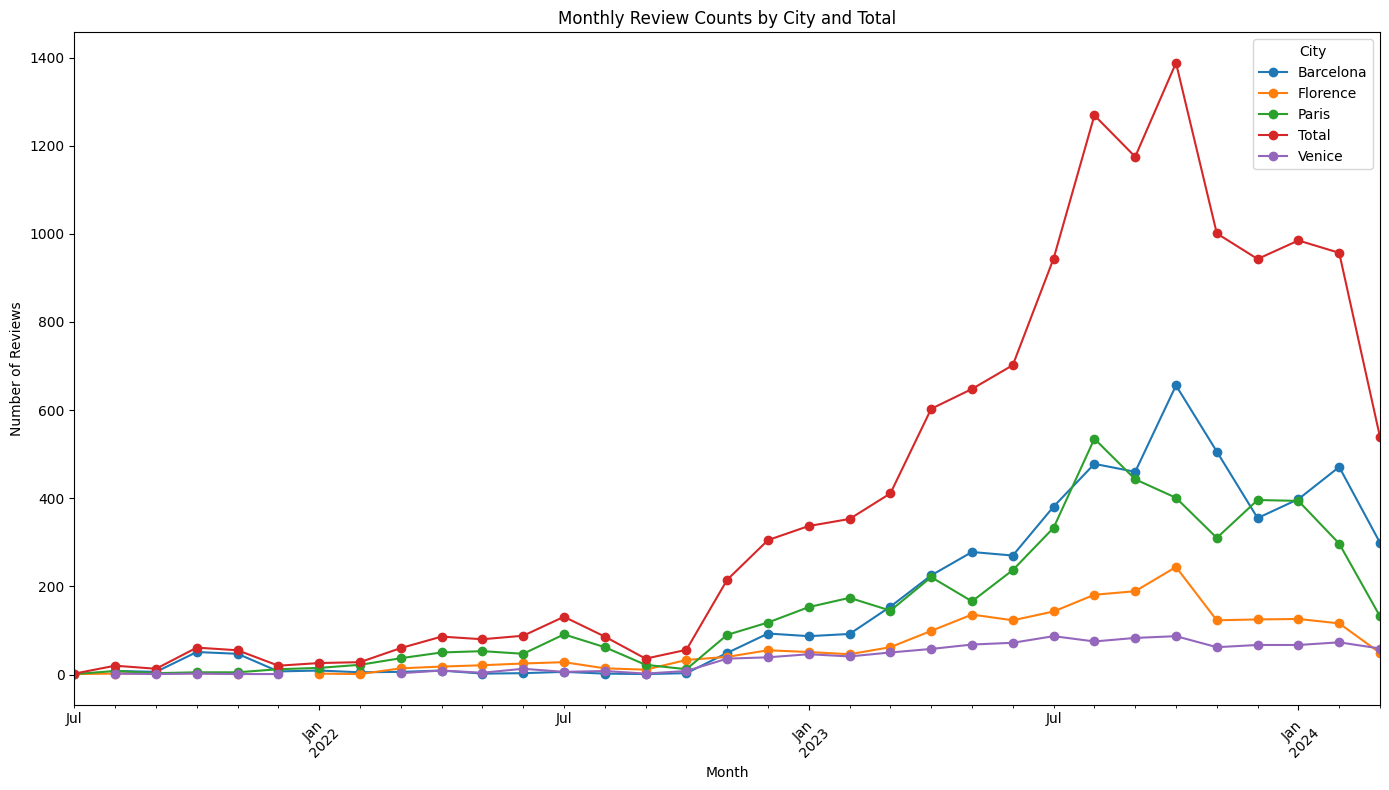

In [24]:
df_new = df.copy()

# Ensure the Review_Date column is in datetime format
df_new['Review_Date'] = pd.to_datetime(df_new['Review_Date'])

# Create a 'YearMonth' column for grouping
df_new['YearMonth'] = df_new['Review_Date'].dt.to_period('M')

# Aggregate data: Count number of reviews per month for each city
monthly_reviews_per_city = df_new.groupby(['City', 'YearMonth']).size().reset_index(name='ReviewCount')

# Aggregate data: Count total number of reviews per month across all cities
total_monthly_reviews = df_new.groupby('YearMonth').size().reset_index(name='ReviewCount')
total_monthly_reviews['City'] = 'Total'

# Combine both DataFrames
combined_reviews = pd.concat([monthly_reviews_per_city, total_monthly_reviews])

# Pivot the data for plotting
pivot_reviews = combined_reviews.pivot(index='YearMonth', columns='City', values='ReviewCount')

# Plotting
pivot_reviews.plot(kind='line', figsize=(14, 8), marker='o')
plt.title('Monthly Review Counts by City and Total')
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

We observed that All cities refelct a huge increasing on reviews numbers from 2023-Jan to 2024-Jan. Also, Barcelona and Paris's reviews number reflect a dramatic increasing and similar trend from 2023 Jan to 2024 Jan.
This results implys that both Barcelona and Paris are popular cities and reviews number is shifting for 2 months in peek time.

## 3. Sentiment Analysis - VADER
#### VADER is sensitive to both case and punctuation, including emojis, which can convey meaningful sentiment information.
##### We use VADER tool to analyze sentiment score, in compund score between -1 to 1.

1. **Valence Scores**:
   - Each word $i$ in the text is assigned a sentiment intensity score $v_i$.
   - Let $n$ be the total number of words in the text.

2. **Normalization**:
   - Normalize the valence scores $v_i$ to a range between -1 and +1.
   - Let $\bar{v}_i$ represent the normalized valence score for word $i$.
   - This normalization ensures that all valence scores are on the same scale.

3. **Summation**:
   - Sum up the normalized valence scores of all words to get the aggregate sentiment score.
   - Let $S$ represent the aggregate sentiment score.
   - Mathematically, $S = \sum_{i=1}^{n} \bar{v}_i$.

4. **Adjustments** (We pick default, default assigned by VADER model):
   - Apply adjustments based on specific rules (negation, punctuation, capitalization, degree modifiers) to modify the sentiment score if needed.

5. **Final Compound Score**:
   - The final compound score, denoted as $C$, is the aggregated score representing the overall sentiment of the text.
   - This score provides a single numerical value summarizing the sentiment of the text.
   - It may incorporate adjustments based on contextual factors.
   - $C = S + A$, where $A$ represents any adjustments applied.


In [25]:
df_new = df.copy()

# Initialize the Sentiment Intensity Analyzer
sia = SentimentIntensityAnalyzer()

# Function to calculate sentiment score
def calculate_sentiment(text):
    return sia.polarity_scores(text)['compound']

# Wrap the .apply function with tqdm for a loading bar
tqdm.pandas(desc="Analyzing Sentiment")

# Apply sentiment analysis only to rows where 'Is_Commented' is True
df_new['Sentiment_Score'] = np.where(df_new['Is_Commented'], df_new['Review_Body'].progress_apply(calculate_sentiment), np.NaN)

# Display the updated DataFrame
display(df_new.tail())

Analyzing Sentiment:   0%|          | 0/13623 [00:00<?, ?it/s]

Analyzing Sentiment: 100%|██████████| 13623/13623 [00:02<00:00, 6492.31it/s]


,Reviewer_Name,Review_Body,Review_Date,Rating,Country,Helpful_Tag,Travel Category,Require_Translate,City,Attraction_Rank,Year,Month,Is_Commented,Sentiment_Score
13730,Anonymous,There are no comments available for this review,2024-03-15,4,NaN,NaN,NaN,False,Venice,top1,2024,March,False,NaN
13731,claude,Take a citizen pass and a vaporetto subscripti...,2024-03-15,5,France,Helpful,solo,True,Venice,top2,2024,March,True,0.4939
13732,Birgit,A highlight of our holiday week in Venice. Gre...,2024-03-15,5,Germany,Helpful,a partner or spouse,True,Venice,top2,2024,March,True,0.9483
13733,Sharon,There are no comments available for this review,2024-03-15,4,Ireland,NaN,friends,False,Venice,top2,2024,March,False,NaN
13734,Anonymous,There are no comments available for this review,2024-03-16,1,NaN,NaN,NaN,False,Venice,top2,2024,March,False,NaN


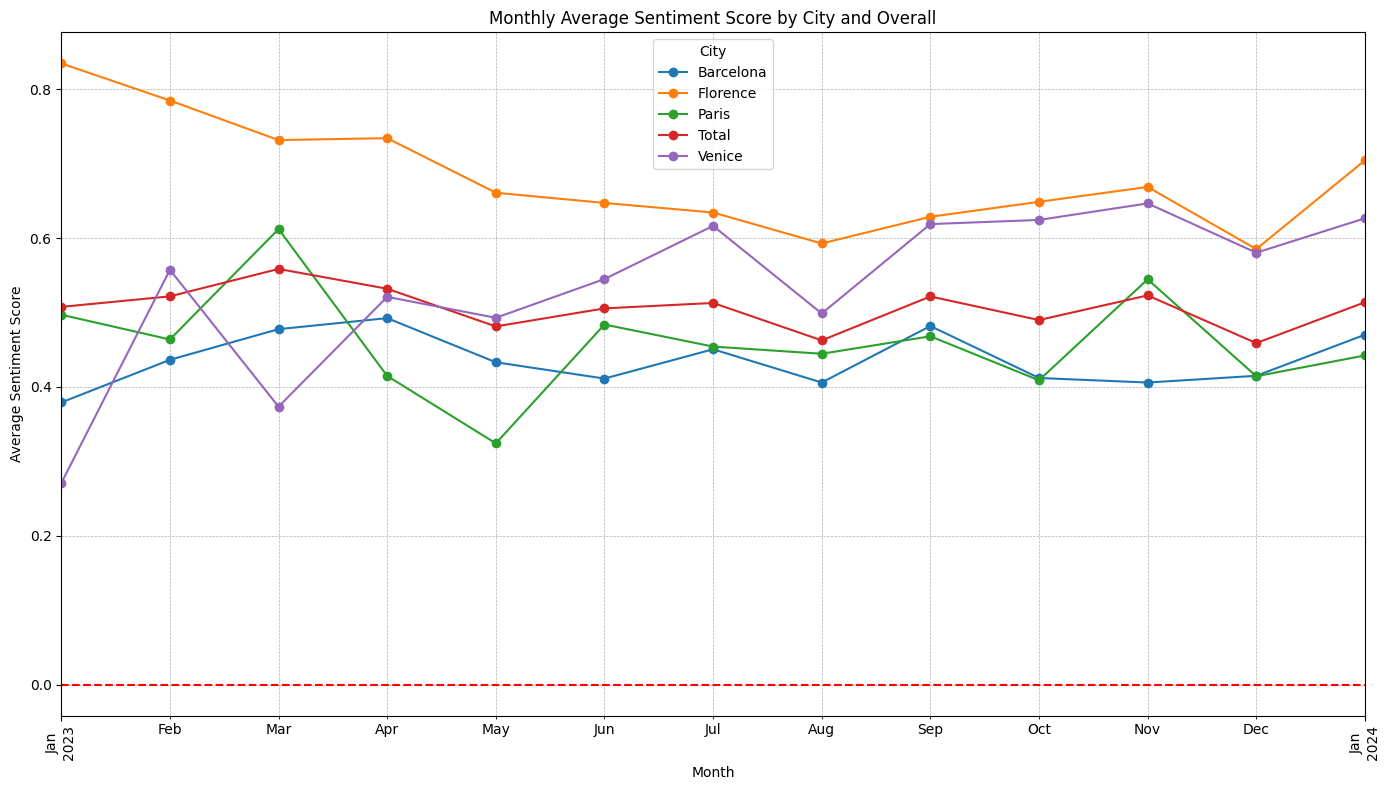

In [26]:
df_new= df_new[df_new['City'] != 'Ljubljana']

# Ensure 'Review_Date' is in datetime format
df_new['Review_Date'] = pd.to_datetime(df_new['Review_Date'])

# Define the date range for selection
start_date = pd.to_datetime('2023-01-01')
end_date = pd.to_datetime('2024-01-31')

# Select rows between start date and end date based on 'Review_Date'
df_new = df_new[(df_new['Review_Date'] >= start_date) & (df_new['Review_Date'] <= end_date)]

# After filtering by date, now create 'YearMonth' for grouping
df_new['YearMonth'] = df_new['Review_Date'].dt.strftime('%Y-%m')
# Group by City and YearMonth, calculate the mean Sentiment_Score
city_monthly_avg = df_new.groupby(['City', 'YearMonth'])['Sentiment_Score'].mean().reset_index()

# Also calculate the overall monthly average across all cities
overall_monthly_avg = df_new.groupby('YearMonth')['Sentiment_Score'].mean().reset_index()
overall_monthly_avg['City'] = 'Total'

# Concatenate both DataFrames
concatenated = pd.concat([city_monthly_avg, overall_monthly_avg])

# Pivot for plotting
pivot_df = concatenated.pivot(index='YearMonth', columns='City', values='Sentiment_Score')

# Convert index to a PeriodIndex to ensure proper sorting and alignment on the plot
pivot_df.index = pd.PeriodIndex(pivot_df.index, freq='M')

# Sort the index
pivot_df = pivot_df.sort_index()

# Plot
pivot_df.plot(figsize=(14, 8), marker='o')
plt.title('Monthly Average Sentiment Score by City and Overall')
plt.xlabel('Month')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=90)
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0 for reference
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

We pick March to Jun, difference we set is May. June to September, difference we set is Augus. From September to January, difference we set is December.
We then have 2 destination, Barcelona and Florence. Barcelona as treatment, Florence as control

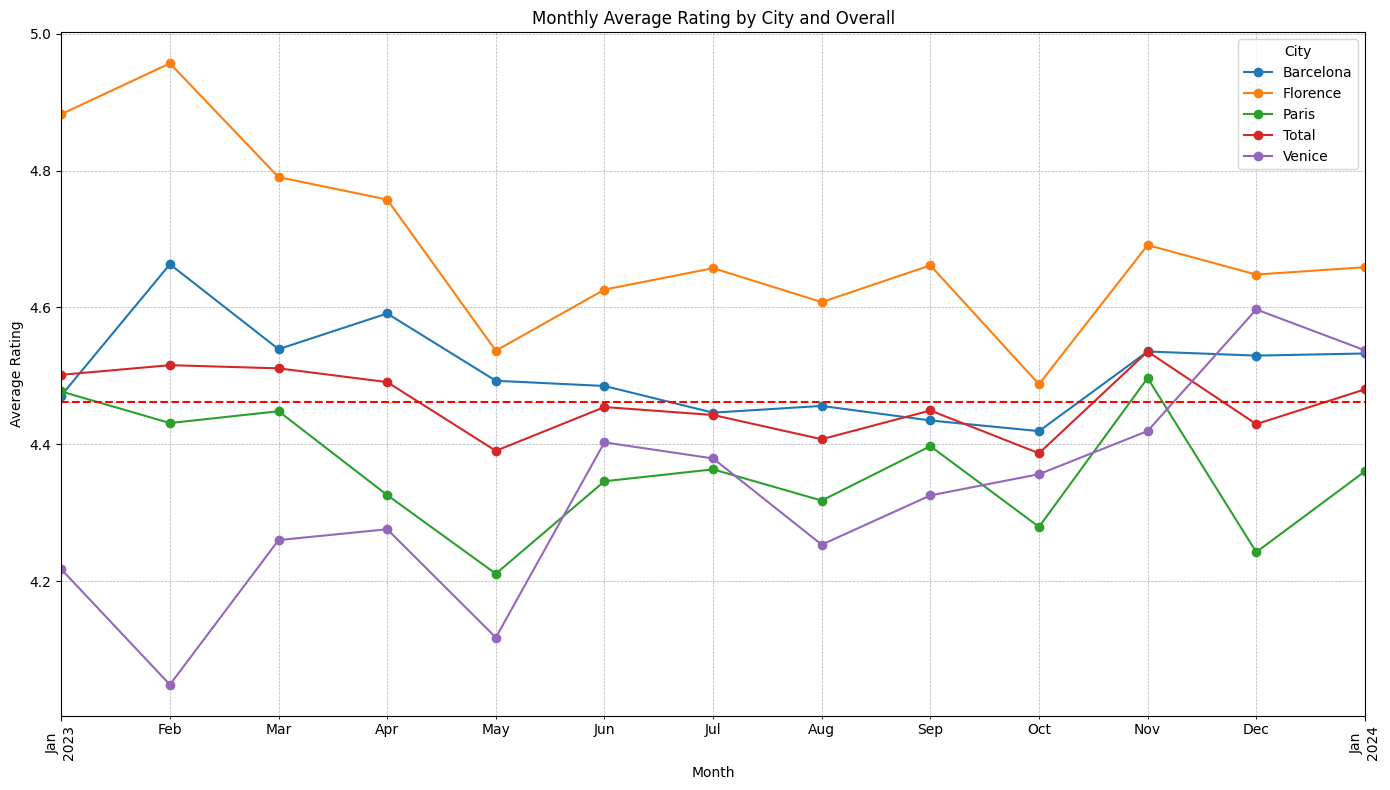

In [27]:
city_monthly_avg_rating = df_new.groupby(['City', 'YearMonth'])['Rating'].mean().reset_index()

# Also calculate the overall monthly average rating across all cities
overall_monthly_avg_rating = df_new.groupby('YearMonth')['Rating'].mean().reset_index()
overall_monthly_avg_rating['City'] = 'Total'

# Concatenate both DataFrames
concatenated_ratings = pd.concat([city_monthly_avg_rating, overall_monthly_avg_rating])

# Pivot for plotting
pivot_df_ratings = concatenated_ratings.pivot(index='YearMonth', columns='City', values='Rating')

# Convert index to a PeriodIndex to ensure proper sorting and alignment on the plot
pivot_df_ratings.index = pd.PeriodIndex(pivot_df_ratings.index, freq='M')

# Sort the index
pivot_df_ratings = pivot_df_ratings.sort_index()

# Plot
pivot_df_ratings.plot(figsize=(14, 8), marker='o')
plt.title('Monthly Average Rating by City and Overall')
plt.xlabel('Month')
plt.ylabel('Average Rating')
plt.xticks(rotation=90)
plt.axhline(y=pivot_df_ratings['Total'].mean(), color='r', linestyle='--')  # Add a horizontal line at the overall average rating for reference
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

### Sentiment score distribution by City and Total

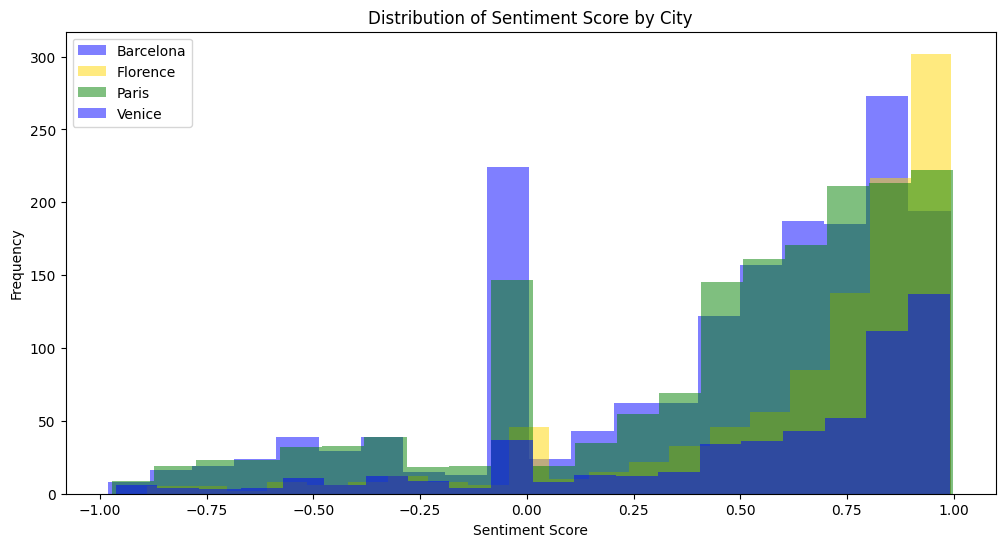

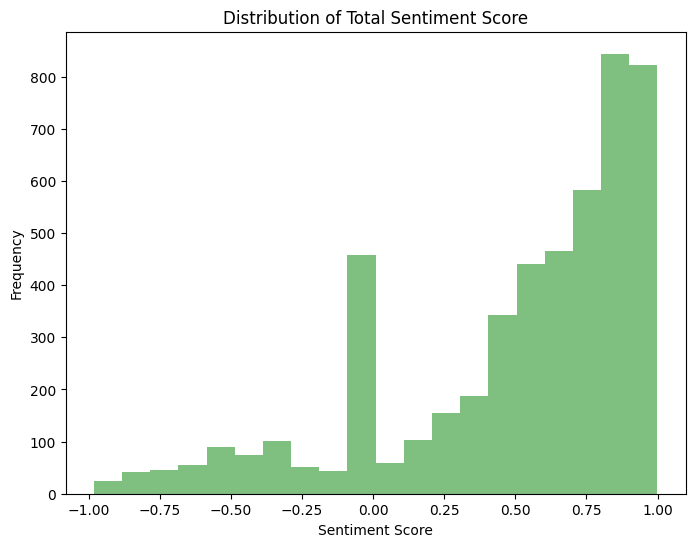

In [28]:
# Plot distribution of sentiment score by city
plt.figure(figsize=(12, 6))
for city in ['Barcelona', 'Florence', 'Paris', 'Venice']:
    if city == 'Florence':
        color = 'gold'
    elif city == 'Paris':
        color = 'green'
    else:
        color = 'blue'
    plt.hist(df_new[df_new['City'] == city]['Sentiment_Score'], bins=20, alpha=0.5, color=color, label=city)
plt.title('Distribution of Sentiment Score by City')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plot distribution of total sentiment score
plt.figure(figsize=(8, 6))
plt.hist(df_new['Sentiment_Score'], bins=20, alpha=0.5, color='green')
plt.title('Distribution of Total Sentiment Score')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

Score in Sentiment is skewed in 2 positions, close 0 and close 1.

### Distribution of Rating

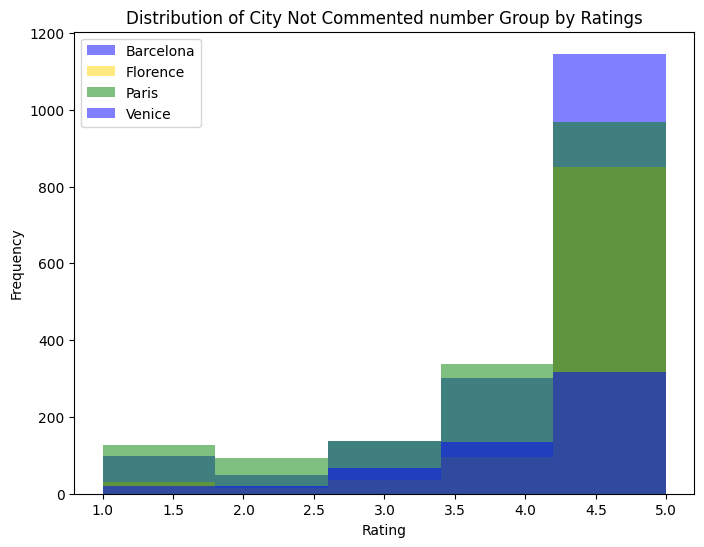

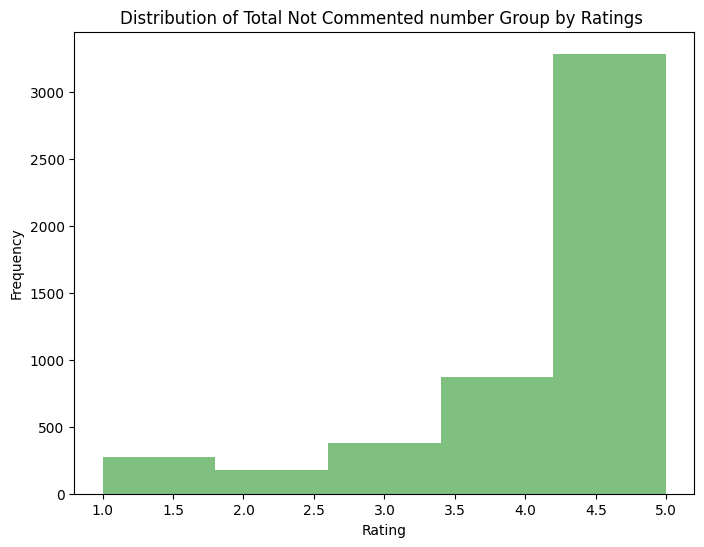

In [36]:
# Plot distribution of sentiment score by city for ratings that are not commented
plt.figure(figsize=(8, 6))
for city in ['Barcelona', 'Florence', 'Paris', 'Venice']:
    if city == 'Florence':
        color = 'gold'
    elif city == 'Paris':
        color = 'green'
    else:
        color = 'blue'
    plt.hist(df_new[(df_new['City'] == city) & df_new['Is_Commented']]['Rating'], bins=5, alpha=0.5, color=color, label=city)
plt.title('Distribution of City Not Commented number Group by Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plot distribution of total sentiment score for ratings that are not commented
plt.figure(figsize=(8, 6))
plt.hist(df_new[df_new['Is_Commented']]['Rating'], bins= 5, alpha=0.5, color='green')
plt.title('Distribution of Total Not Commented number Group by Ratings ')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

By comparing Distribution of reviews number in Ratings and Sentiment Score. It appears that, score in Sentiment is skewed in 2 positions, close 0 and close 1. But Ratings is only skewed close 5. This might becasue there is some bias between Rating and Sentiment Score, **we can't directly impute sentiment score by Rating. We can't directly impute Sentiment Score by KNN of rating**. We try to look at **possiblity of adding Year_Months**.

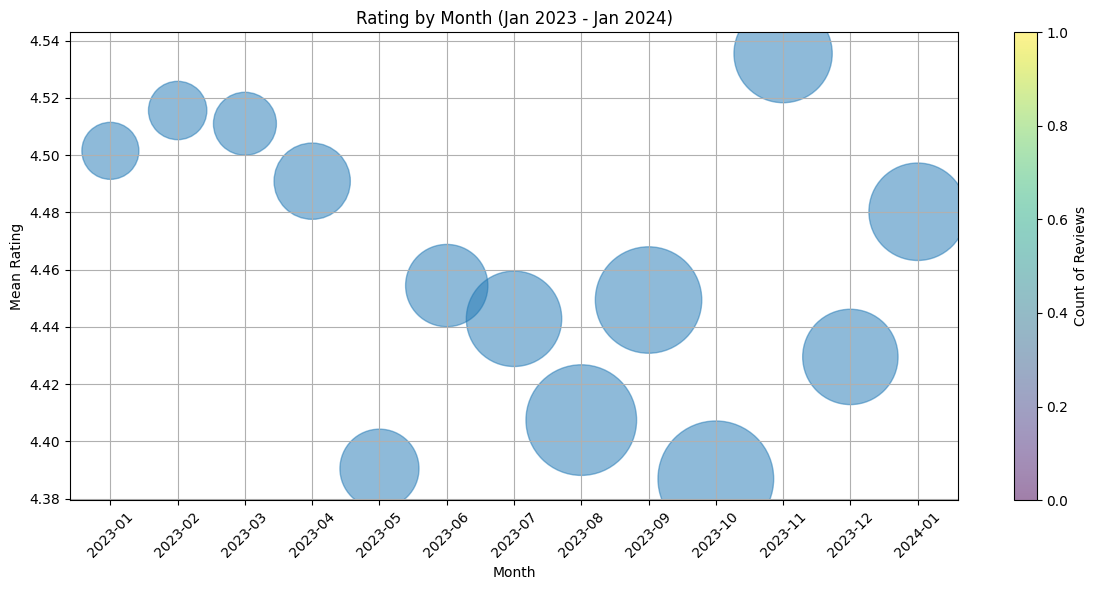

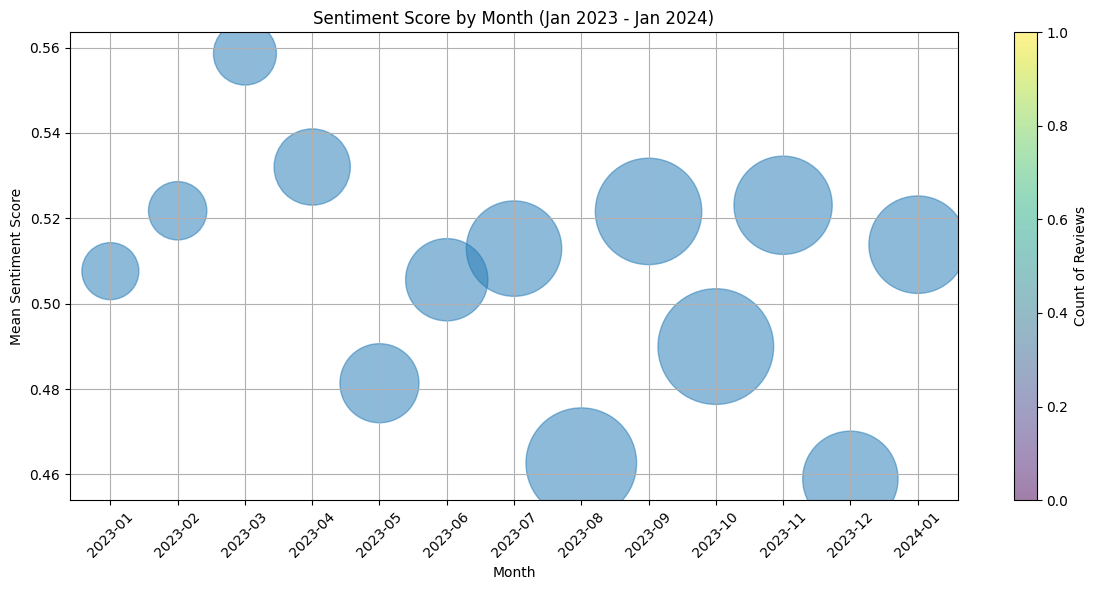

In [30]:
# Group the data by month and calculate the mean sentiment score and count of reviews for each month
monthly_data = df_new.groupby(df_new['Review_Date'].dt.to_period('M')).agg({'Rating': 'mean', 'Sentiment_Score': 'mean', 'Review_Date': 'count'})

# Rename the 'Review_Date' column
monthly_data = monthly_data.rename(columns={'Review_Date': 'Count_Reviews'})

# Filter the DataFrame to include dates from January 2023 to January 2024
monthly_data = monthly_data.loc['2023-01':'2024-01']

# Convert Period index to strings
monthly_data.index = monthly_data.index.strftime('%Y-%m')

# Set the size of bubbles proportional to the count of reviews
sizes = monthly_data['Count_Reviews'] * 5

# Plot the bubble plot for Rating
plt.figure(figsize=(12, 6))
plt.scatter(monthly_data.index, monthly_data['Rating'], s=sizes, alpha=0.5)
plt.title('Rating by Month (Jan 2023 - Jan 2024)')
plt.xlabel('Month')
plt.ylabel('Mean Rating')
plt.colorbar(label='Count of Reviews')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot the bubble plot for Sentiment Score
plt.figure(figsize=(12, 6))
plt.scatter(monthly_data.index, monthly_data['Sentiment_Score'], s=sizes, alpha=0.5)
plt.title('Sentiment Score by Month (Jan 2023 - Jan 2024)')
plt.xlabel('Month')
plt.ylabel('Mean Sentiment Score')
plt.colorbar(label='Count of Reviews')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

From observing bubble chart in mean sentiment score and mean rating by month, we observed that, in size and color (distribution&number) of bubble is kind of similar. This prove that distribution of number and mean in rating is kind of related with sentiment score.

Octobor and November show a huge difference in bubble positions between rating plot and sentiment score plot.
Futhure slight differences of bubbles, also happened in months, March, May, July, Octobor, November and December.

But lots of distribution differences between Rating and Sentiment Score, tells us **we can't impute by not-commented reviews by KNN in rating and Months also**.

### Final Imputing Solution - Impute sentiment score by mean of that month

In [31]:
from sklearn.impute import SimpleImputer

#df_new['Review_Date'] = pd.to_datetime(df_new['Review_Date'])
# Define the date range for selection
start_date = pd.to_datetime('2023-01-01')
end_date = pd.to_datetime('2024-01-31')

# Select rows between start date and end date based on 'Review_Date'
df_copy = df_new[(df_new['Review_Date'] >= start_date) & (df_new['Review_Date'] <= end_date)]

# Convert 'Review_Date' to datetime and create a new column for year and month
df_copy['Review_Date'] = pd.to_datetime(df_copy['Review_Date'])
df_copy['Year_Month'] = df_copy['Review_Date'].dt.to_period('M')

# Group by 'Year_Month' and calculate the mean of 'Sentiment_Score' for each month
monthly_means = df_copy.groupby('Year_Month')['Sentiment_Score'].mean()

# Create a SimpleImputer instance with strategy='constant' and fill_value as the mean of each month's sentiment score
imputer = SimpleImputer(strategy='constant', fill_value=monthly_means.mean())

# Impute missing values for 'Sentiment_Score' only
df_copy['Sentiment_Score'] = imputer.fit_transform(df_copy[['Sentiment_Score']])

display(df_copy.head())

,Reviewer_Name,Review_Body,Review_Date,Rating,Country,Helpful_Tag,Travel Category,Require_Translate,City,Attraction_Rank,Year,Month,Is_Commented,Sentiment_Score,YearMonth,Year_Month
307,Sylvie,No welcome and self-guided support🥴,2023-01-01,3,France,Helpful,NaN,True,Barcelona,top1,2023,January,True,0.056700,2023-01,2023-01
308,Dobromir,There are no comments available for this review,2023-01-01,4,Bulgaria,NaN,NaN,False,Barcelona,top1,2023,January,False,0.506917,2023-01,2023-01
309,Paolo,Audio guide not present and not explained,2023-01-02,3,Switzerland,Helpful,NaN,True,Barcelona,top1,2023,January,True,0.000000,2023-01,2023-01
310,Fadhil,Too many steps to get only to the ground floor...,2023-01-02,2,Switzerland,Helpful,NaN,True,Barcelona,top1,2023,January,True,0.636100,2023-01,2023-01
311,Brunella,There are no comments available for this review,2023-01-02,5,Italy,NaN,NaN,False,Barcelona,top1,2023,January,False,0.506917,2023-01,2023-01


### Mean of Sentiment Score distribution by month after simple imputer by mean

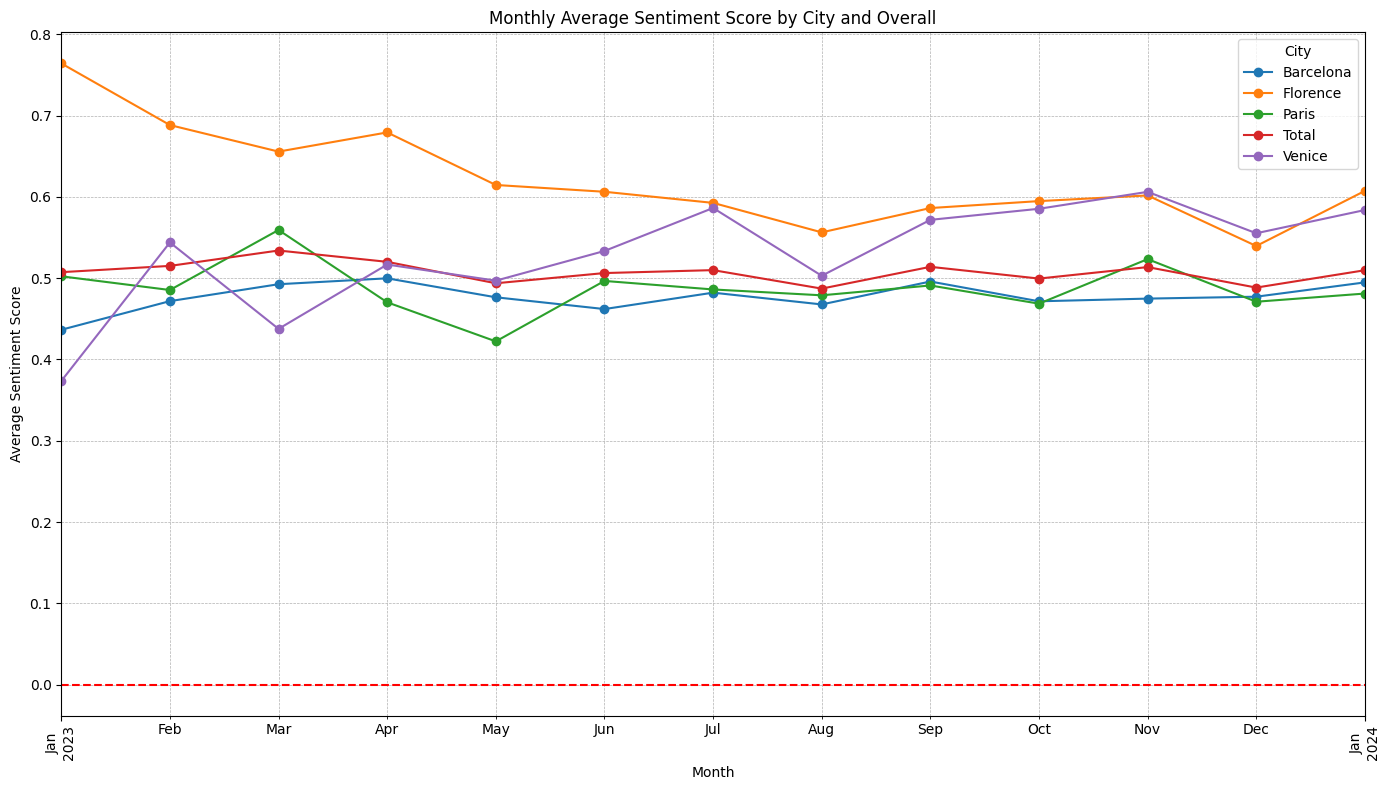

In [32]:
df_copy= df_copy[df_copy['City'] != 'Ljubljana']

# Ensure 'Review_Date' is in datetime format
df_copy['Review_Date'] = pd.to_datetime(df_copy['Review_Date'])

# Define the date range for selection
start_date = pd.to_datetime('2023-01-01')
end_date = pd.to_datetime('2024-01-31')

# Select rows between start date and end date based on 'Review_Date'
df_copy = df_copy[(df_copy['Review_Date'] >= start_date) & (df_copy['Review_Date'] <= end_date)]

# After filtering by date, now create 'YearMonth' for grouping
df_copy['YearMonth'] = df_copy['Review_Date'].dt.strftime('%Y-%m')
# Group by City and YearMonth, calculate the mean Sentiment_Score
city_monthly_avg = df_copy.groupby(['City', 'YearMonth'])['Sentiment_Score'].mean().reset_index()

# Also calculate the overall monthly average across all cities
overall_monthly_avg = df_copy.groupby('YearMonth')['Sentiment_Score'].mean().reset_index()
overall_monthly_avg['City'] = 'Total'

# Concatenate both DataFrames
concatenated = pd.concat([city_monthly_avg, overall_monthly_avg])

# Pivot for plotting
pivot_df = concatenated.pivot(index='YearMonth', columns='City', values='Sentiment_Score')

# Convert index to a PeriodIndex to ensure proper sorting and alignment on the plot
pivot_df.index = pd.PeriodIndex(pivot_df.index, freq='M')

# Sort the index
pivot_df = pivot_df.sort_index()

# Plot
pivot_df.plot(figsize=(14, 8), marker='o')
plt.title('Monthly Average Sentiment Score by City and Overall')
plt.xlabel('Month')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=90)
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0 for reference
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

Sentiment Score after imputing by mean showing an more smoothly line in both Barcelona and Florence. This indicates that **not-commented reviews has an indicated effects** on each month and therefore **remove some noise** trend from before socre. 
#### This effect highly suggested to include imputing not-commented reviews by mean.

In [33]:
######## save to local ##########
# Selecting specific columns from df_new
cleaned_columns = ['Reviewer_Name', 'Review_Body', 'Review_Date', 'Rating', 'Country', 
                    'Helpful_Tag', 'Travel Category', 'Require_Translate', 'City', 
                    'Attraction_Rank', 'Is_Commented', 'Sentiment_Score', 'Year_Month']

# Creating a new DataFrame with only the selected columns
df_copy = df_copy[cleaned_columns]

# Specify file path and name
save_sentiment_scored_and_filtered_from_2023_to_2034_Barcelona_Paris_file_path = 'C:/Users/surface/DSDM/Semesters/semester2/text mining/Final Project/nlp_data/Step_1st_nlp_sentiment_scored_and_filtered_from_2023_to_2034_Barcelona_Paris_file_path.csv'

# modify format
# Save the combined DataFrame to a CSV file
df_copy.to_csv(save_sentiment_scored_and_filtered_from_2023_to_2034_Barcelona_Paris_file_path, index=False, encoding='utf-8')  # `index=False` to avoid writing row indices to the file